In [1]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
# import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='keep')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1438) (294, 1438) (530, 1438) (803, 1438)


In [3]:
meta.head(5)

,varlab,type,one_topic,dtype
new_name,,,,
f1a2,Were you present at the birth?,Binary,parenting,float64
f1a3,Have you held baby(ies)?,Binary,parenting,float64
f1a4,Will the baby(ies) have your last name?,Binary,parenting,float64
f1a5,Will your name be on the birth certificate?,Binary,parenting,float64
f1a6,Do you have other biological children?,Binary,health_and_health_behavior,float64


# Model

In [4]:
def run_model(train, target='gpa', classifier=False):

    X_train, y_train = prepare_data(train, target)
    print(X_train.shape, y_train.shape)
    # get only predictors
    
    print(X_train.shape, y_train.shape)

    # categorical_transformer = OneHotEncoder(handle_unknown='ignore')


    numerical_features = cols_per_type(X_train, 'Continuous')
    categorical_features = cols_per_type(X_train, 'Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    ordinal_features = cols_per_type(X_train, 'Ordinal')

    preprocessor = make_column_transformer(
        ('passthrough', categorical_features),
        ('passthrough', numerical_features),
        ('passthrough', ordinal_features),
        ('passthrough', binary_features)
    )

    search_space = {
        'regressor__learning_rate': space.Real(0.01, 0.06),
        'regressor__max_depth': space.Integer(5, 10),
    }

    if classifier:
        score = 'neg_brier_score'
        lgbm = LGBMClassifier()
        # catboost = CatBoostClassifier(
        #     eval_metric='Logloss', loss_function='Logloss', thread_count=-1,cat_features=categorical_features)
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
    else:
        # catboost = CatBoostRegressor(eval_metric='RMSE', thread_count=-1,cat_features=categorical_features)
        lgbm = LGBMRegressor()
        score = 'neg_mean_squared_error'

    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', lgbm)])

    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=2,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=32
    )

    # ytrain shape
    print(y_train.shape)
    model.fit(X_train, y_train)

    return model


# GPA

In [5]:
gpa_model = run_model(train,target='gpa', classifier=False)

(937, 1432) (937,)
(937, 1432) (937,)
(937,)


In [6]:
# Woodcock-Johnson Test 10 standard score
#  f3b3	0.01004	How many times have you been apart for a week or more?
#  m2c3j	0.00904	How many days a week does father put child to bed?

In [7]:
score_model(gpa_model,'gpa',test,leaderboard,holdout,classifier=False)

Metric: mean_squared_error
Best CV score: 0.3978
Standard deviation of CV scores: 0.0337
Mean CV score: 0.4050
Test MSE: 0.4265
Test R2: 0.0629
Leaderboard MSE: 0.4506
Leaderboard R2: -0.1537
Holdout MSE: 0.4727
Holdout R2: -0.1197


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


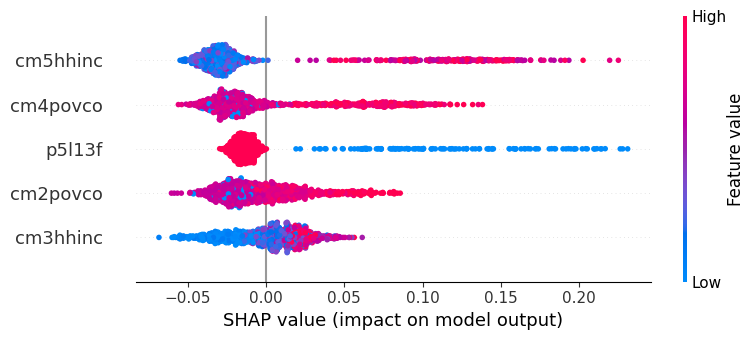

{('Constructed - Household income (with imputed values)',): 'cm3hhinc',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cm4povco',
 ('L13F. Gifted and talented program',): 'p5l13f',
 ("Constructed - Mother's Household income (with imputed values)",): 'cm5hhinc'}

In [8]:
shap_show(gpa_model, alldata, target='gpa')

# Material Hardship

In [9]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

(1167, 1432) (1167,)
(1167, 1432) (1167,)
(1167,)


In [10]:
model_materialHardship.best_params_

OrderedDict([('regressor__learning_rate', 0.013587610784167528),
             ('regressor__max_depth', 10)])

In [11]:
score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)


Metric: mean_squared_error
Best CV score: 0.0204
Standard deviation of CV scores: 0.0020
Mean CV score: 0.0205
Test MSE: 0.0238
Test R2: 0.1286
Leaderboard MSE: 0.0307
Leaderboard R2: -0.0716
Holdout MSE: 0.0274
Holdout R2: -0.1231


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


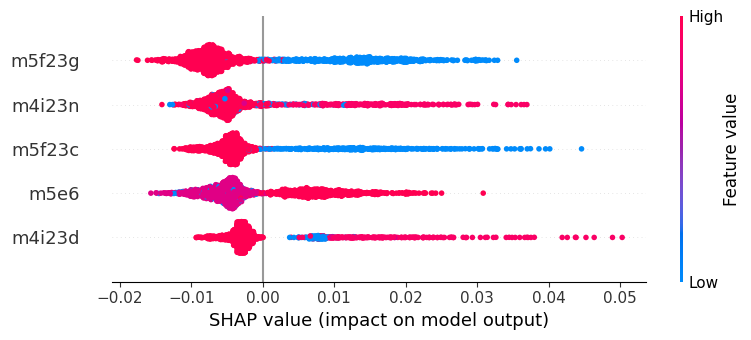

{("In past year, did not pay full amt rent/mortgage payments b/c wasn't enough",): 'm4i23d',
 ('E6. Mother could count on someone to co-sign for a bank loan for $1000',): 'm5e6',
 ('F23C. Did not pay full amount of rent/mortgage payments in past 12 months',): 'm5f23c',
 ("In past year, phone service disconnected b/c wasn't enough money?",): 'm4i23n',
 ('F23G. Borrowed money from friends/family to help pay bills in past 12 months',): 'm5f23g'}

In [12]:
shap_show(model_materialHardship, alldata, target='materialHardship')


# Grit


In [13]:
model_grit = run_model(train,target='grit', classifier=False)

(1136, 1432) (1136,)
(1136, 1432) (1136,)
(1136,)


In [14]:
# Value 2 for “(He/she) stares blankly.”
#  hv4r10a_3_1	0.01520	Value 1 for “Any hazardous condition 3: broken glass”
#  hv5_wj9raw	0.00946	Woodcock-Johnson Test 9 raw score

In [15]:
model_grit.best_params_

OrderedDict([('regressor__learning_rate', 0.013587610784167528),
             ('regressor__max_depth', 10)])

In [16]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Metric: mean_squared_error
Best CV score: 0.2358
Standard deviation of CV scores: 0.0301
Mean CV score: 0.2411
Test MSE: 0.2366
Test R2: -0.0049
Leaderboard MSE: 0.2316
Leaderboard R2: -0.0539
Holdout MSE: 0.2582
Holdout R2: -0.0808


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


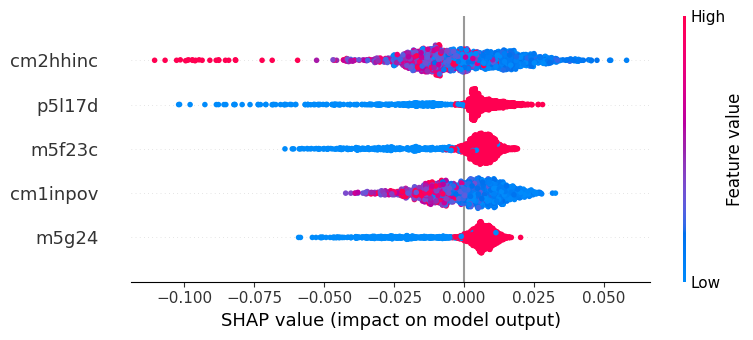

{('G24. Ever had a spell/attack when you felt frightened/anxious/uneasy',): 'm5g24',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cm1inpov',
 ('F23C. Did not pay full amount of rent/mortgage payments in past 12 months',): 'm5f23c',
 ("L17D. Discussed homework not done with child's teacher in this/last school year",): 'p5l17d',
 ('Constructed - Household income (with imputed values)',): 'cm2hhinc'}

In [17]:
shap_show(model_grit, alldata, target='grit')

# Eviction

In [18]:
model_eviction = run_model(train,target='eviction', classifier=True)

(1168, 1432) (1168,)
(1168, 1432) (1168,)
(1168,)


In [19]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.0515
Test F1: 0.0000
Leaderboard Brier: 0.0660
Leaderboard F1: 0.0541


In [20]:
# Value “yes” for “Telephone service disconnected because wasn’t enough money in past 12 months.”
#  m5f23c_1	0.05842	Value “yes” for “Did not pay full amount of rent/mortgage payments in past 12 months.”
#  m3i4	0.02062	How much rent do you pay each month?

In [21]:
# shap_show(model_eviction, alldata, target='eviction')

In [22]:
# top5 = ['m5f23k','p3m39','m5i3c']

# meta[meta.index.isin(top5)].varlab.values

# jobTraining

In [23]:
# Value “yes” for “In the last 2 years, have you taken any classes to improve your job skills?”
#  m5i1_1	0.06355	Value “yes” for “You are currently attending any school/trainings program/classes.”
#  m5i3b_1	0.06355	Value “yes” for “You have taken classes to improve job skills since last interview.”

In [24]:
model_job = run_model(train,target='jobTraining', classifier=True)

(1169, 1432) (1169,)
(1169, 1432) (1169,)
(1169,)


In [25]:
score_model(model_job, 'jobTraining', test, leaderboard, holdout=None, classifier=True)

Test Brier: 0.3048
Test F1: 0.4258
Leaderboard Brier: 0.3811
Leaderboard F1: 0.2348


In [26]:
# shap_show(model_job, alldata, target='jobTraining',n=5)

# Layoff

In [27]:
# mount of money spent eating out in last month
#  m3i0q	0.01678	How important is it to serve in the military when at war?
#  f5i13	0.01678	How much you earn in that job, before taxes

In [28]:
model_layoff = run_model(train, target='layoff', classifier=True)

(1026, 1432) (1026,)
(1026, 1432) (1026,)
(1026,)


In [29]:
model_layoff.best_params_

OrderedDict([('regressor__learning_rate', 0.013587610784167528),
             ('regressor__max_depth', 10),
             ('regressor__scale_pos_weight', 12)])

In [30]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout, classifier=True)

Test Brier: 0.2749
Test F1: 0.2247
Leaderboard Brier: 0.3151
Leaderboard F1: 0.1773
Holdout Brier: 0.3163


In [31]:
# shap_show(model_layoff, alldata, target='layoff')